In [1]:
# Import all necessary libaries

import numpy as np
import matplotlib.pyplot as plt

from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator 
from keras.layers import Flatten, Dense 
from keras.applications import VGG16

from skimage.transform import resize

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


In [2]:
# Datasets path
train_path = 'dataset/train/'
test_path = 'dataset/test'

# Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)
    
#vgg_conv.summary()

W0618 18:02:06.108179 140078826895232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 18:02:06.132754 140078826895232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 18:02:06.136824 140078826895232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0618 18:02:06.172958 140078826895232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0618 18:02:06.564872 140078826895232 deprecation_wrapp

<keras.engine.input_layer.InputLayer object at 0x7f664e24ee48> False
<keras.layers.convolutional.Conv2D object at 0x7f664e25c3c8> False
<keras.layers.convolutional.Conv2D object at 0x7f664e25c278> False
<keras.layers.pooling.MaxPooling2D object at 0x7f664da04908> False
<keras.layers.convolutional.Conv2D object at 0x7f664e25cbe0> False
<keras.layers.convolutional.Conv2D object at 0x7f664da33128> False
<keras.layers.pooling.MaxPooling2D object at 0x7f664da33a58> False
<keras.layers.convolutional.Conv2D object at 0x7f664d9ce0b8> False
<keras.layers.convolutional.Conv2D object at 0x7f664d9e7278> False
<keras.layers.convolutional.Conv2D object at 0x7f664d97abe0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f664d993f28> False
<keras.layers.convolutional.Conv2D object at 0x7f664d9ab6a0> False
<keras.layers.convolutional.Conv2D object at 0x7f664d957358> False
<keras.layers.convolutional.Conv2D object at 0x7f664d957be0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f664d90bb70>

In [3]:
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

W0618 18:02:07.532164 140078826895232 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                20500     
Total params: 40,426,324
Trainable params: 32,791,060
Non-trainable params: 7,635,264
_________________________________________________________________


In [4]:
# Padding functions for data preprocessing
def resize_pad(img):
    old_size = img.shape[:2]
    ratio = 240. / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    img = resize(img, output_shape=new_size, mode='edge', preserve_range=True)

    delta_w = 240 - new_size[1]
    delta_h = 240 - new_size[0]
    padding = ((delta_h // 2, delta_h - (delta_h // 2)), (delta_w // 2, delta_w - (delta_w // 2)), (0, 0))

    img = np.pad(img, padding, 'edge')

    return img

def preprocessing_train(x):
    x = resize_pad(x)
    return x

def preprocessing_val(x):
    x = resize_pad(x)
    return x

# Preapre data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_train,
    rescale=1. / 255,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_val,
    rescale=1. / 255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    color_mode='rgb',
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    train_path,
    color_mode='rgb',
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=0
)

labels = (train_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())

print(labels)

Found 3709 images belonging to 20 classes.
Found 404 images belonging to 20 classes.
{0: 'Brick_1x1', 1: 'Brick_1x2', 2: 'Brick_1x3', 3: 'Brick_1x4', 4: 'Brick_2x2', 5: 'Brick_2x2_L', 6: 'Brick_2x2_Slope', 7: 'Brick_2x3', 8: 'Brick_2x4', 9: 'Plate_1x1', 10: 'Plate_1x1_Round', 11: 'Plate_1x1_Slope', 12: 'Plate_1x2', 13: 'Plate_1x2_Grill', 14: 'Plate_1x3', 15: 'Plate_1x4', 16: 'Plate_2x2', 17: 'Plate_2x2_L', 18: 'Plate_2x3', 19: 'Plate_2x4'}


In [5]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc', 'top_k_categorical_accuracy'])

# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)


W0618 18:02:08.081729 140078826895232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0618 18:02:08.218258 140078826895232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
116/115 [==============================] - 136s 1s/step - loss: 2.1306 - acc: 0.3386 - top_k_categorical_accuracy: 0.7006 - val_loss: 1.4486 - val_acc: 0.5421 - val_top_k_categorical_accuracy: 0.9109
Epoch 2/50
116/115 [==============================] - 121s 1s/step - loss: 1.2961 - acc: 0.5648 - top_k_categorical_accuracy: 0.9232 - val_loss: 1.1497 - val_acc: 0.6262 - val_top_k_categorical_accuracy: 0.9332
Epoch 3/50
116/115 [==============================] - 126s 1s/step - loss: 0.9571 - acc: 0.6700 - top_k_categorical_accuracy: 0.9590 - val_loss: 0.8860 - val_acc: 0.7327 - val_top_k_categorical_accuracy: 0.9653
Epoch 4/50
116/115 [==============================] - 128s 1s/step - loss: 0.7817 - acc: 0.7342 - top_k_categorical_accuracy: 0.9749 - val_loss: 0.8197 - val_acc: 0.7649 - val_top_k_categorical_accuracy: 0.9752
Epoch 5/50
116/115 [==============================] - 128s 1s/step - loss: 0.6590 - acc: 0.7773 - top_k_categorical_accuracy: 0.9830 - val_loss: 0.7963 - va

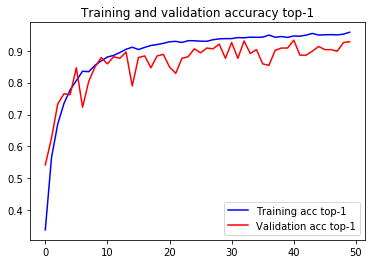

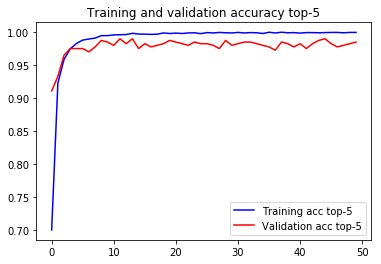

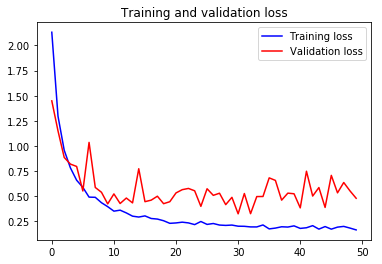

In [6]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
top_k_categorical_accuracy = history.history['top_k_categorical_accuracy']
val_top_k_categorical_accuracy = history.history['val_top_k_categorical_accuracy']

 
epochs = range(len(acc))
 
# Top-1 accuracy
plt.plot(epochs, acc, 'b', label='Training acc top-1')
plt.plot(epochs, val_acc, 'r', label='Validation acc top-1')
plt.title('Training and validation accuracy top-1')
plt.legend()
 
plt.figure()

# Top-5 accuracy
plt.plot(epochs, top_k_categorical_accuracy, 'b', label='Training acc top-5')
plt.plot(epochs, val_top_k_categorical_accuracy, 'r', label='Validation acc top-5')
plt.title('Training and validation accuracy top-5')
plt.legend()

plt.figure()

# Loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [7]:
# Create a generator for test dataset
validation_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(240, 240),
        batch_size=10,
        class_mode='categorical',
        shuffle=False)
 

ground_truth = validation_generator.classes
 
# Labels into dictionary
label2index = validation_generator.class_indices
idx2label = dict((v,k) for k,v in label2index.items())
 
# Predictions
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

Found 467 images belonging to 20 classes.
47/46 [==============================] - 10s 206ms/step


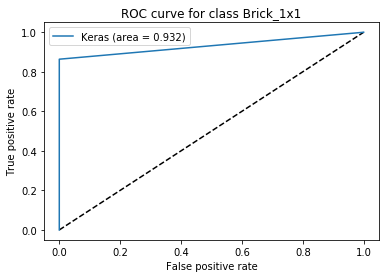

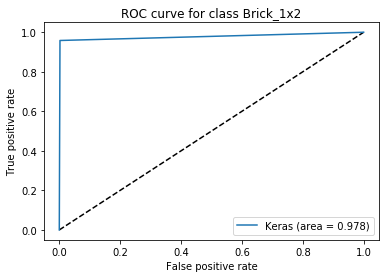

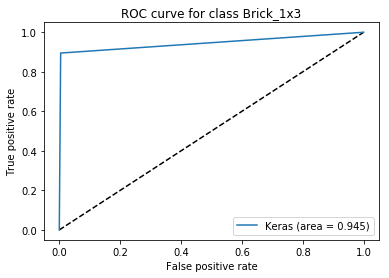

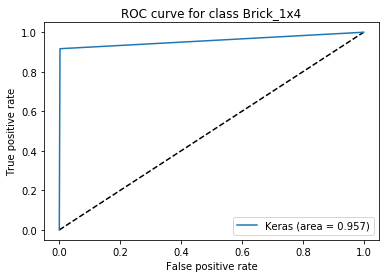

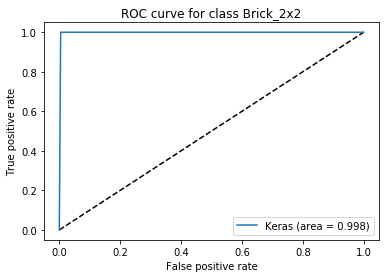

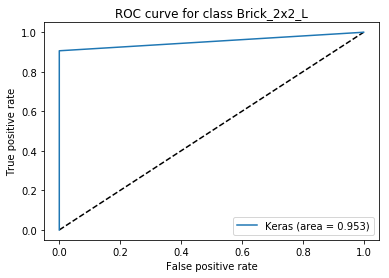

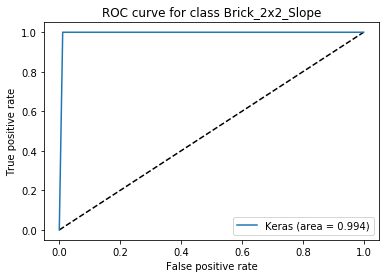

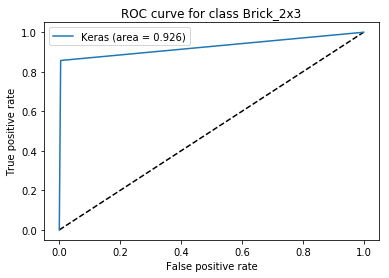

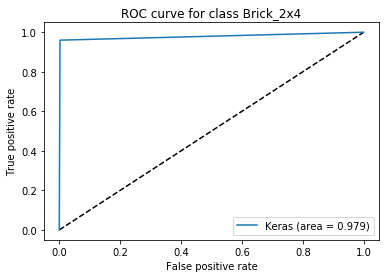

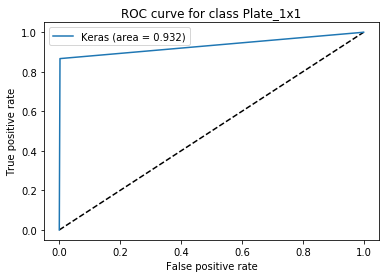

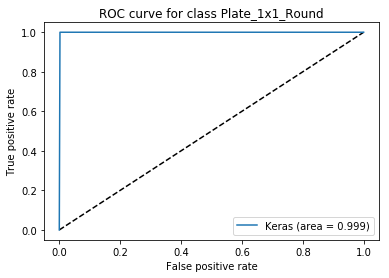

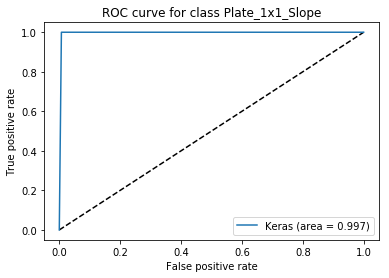

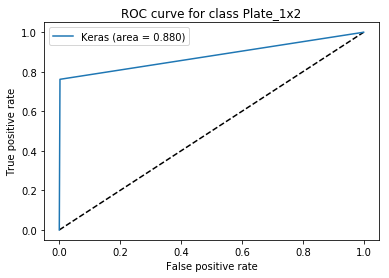

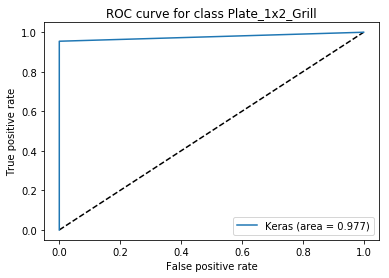

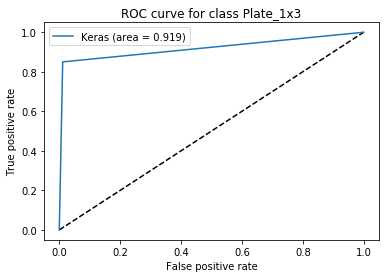

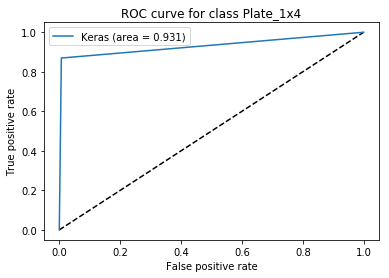

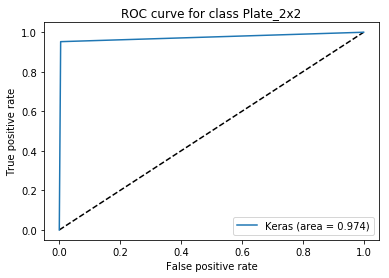

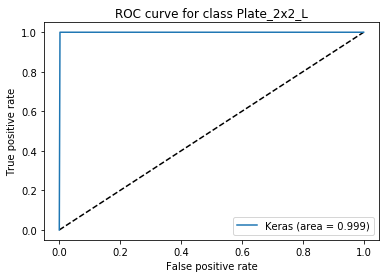

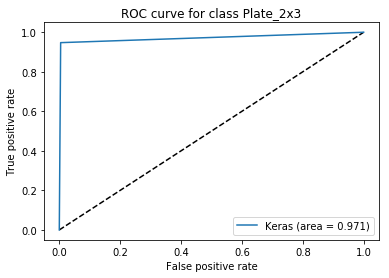

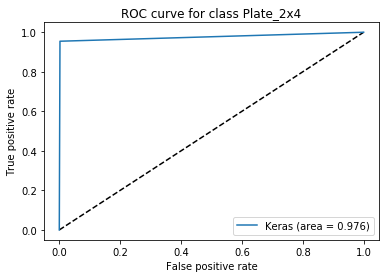

In [8]:
# Binarize and transpose results and ground truth
y = label_binarize(ground_truth, classes=[x for x in range(20)])
y_pred = label_binarize(predicted_classes, classes=[x for x in range(20)])
y = y.T
y_pred = y_pred.T

# Display all roc's curves
for i in range(20):
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y[i], y_pred[i])

  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(i+1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve for class '+ idx2label[i])
  plt.legend(loc='best')
  plt.show()


In [9]:
good_predictions = 0
for prediction, label in zip(predicted_classes, ground_truth):
  if prediction == label:
    good_predictions += 1

result = good_predictions/len(predicted_classes)

print("Result: ", result)
print("Good predictions: ", good_predictions)
print("All predictions: ", len(predicted_classes))

Result:  0.9271948608137045
Good predictions:  433
All predictions:  467
